# TL;DR Cómo usar Python para generar un gráfico basado en la Medición de Sensibilidad de Precios de Van Westendorp (en adelante, MSP).

## Paso Previo: los datos  
Para obtener el gráfico sólo hace falta el conjunto de datos de una encuesta con las siguientes preguntas:
1. ¿Cuál consideras el precio de este producto al cual ya es demasiado caro y ya no lo comprarías?
2. ¿A cuál precio consideras que comprarías el producto aunque te parezca caro?
3. ¿En qué precio seguirías comprando aún considerándolo barato?
4. ¿Cuál sería el precio en el que lo considerarías demasiado barato al punto de dudar sobre su calidad y dejarías de comprarlo?
La tabla debe tener 4 columnas:

        | Demasiado Barato | Barato | Caro | Demasiado Caro |
        | ---------------- | ------ | ---- | -------------- |
        |        1         |    2   |  3   |          4     |


Para generar el gráfico de Van Westendorp, debes agregar tu archivo a este directorio. Admite archivos csv, json y excel.


-----  

Dado un conjunto de datos donde los encuestados indican lo que consideran el precio "demasiado barato", "barato", "caro" y "demasiado caro" para el producto en estudio:
* Usamos la biblioteca `pandas` para transformar el contenido del archivo de la encuesta en un _data frame_. 
Agregamos dos nuevas columnas:
  - una llamada "FRA" con la frecuencia relativa acumulada de los índices + 1 del conjunto de datos, y
  - otro llamada "FRA Inversa" que es igual a 1 - FRA de cada entrada
* Con esa información usando la biblioteca `matplotlib` trazamos las líneas:
  - "demasiado barato" y "barato" que tendrán pendiente negativa, mientras que
  - "caro" y "demasiado caro" tendrán pendiente positiva (Detalles sobre esto más adelante)
* Encontramos las cuatro intersecciones y las rotulamos según su valor correspondiente:
  - La intersección de "demasiado barato" y "demasiado caro" es el Punto de Precio Óptimo (PPO)
  - La intersección de "demasiado barato" y "caro" es el Punto Marginal de Coste Bajo(PMCB)
  - La intersección de "barato" y "demasiado caro" es el Punto Marginal de Coste Alto (PMCA), y
  - La intersección de "barato" y "caro" es el Punto de Indiferencia(PI)
 
* Finalmente agregamos debajo del gráfico un bloque de texto para indicar el valor de las intercepciones

Si solo te interesa usar el código, simplemente agrega el archivo de tu encuesta a este directorio y sigue las instrucciones de la siguiente celda.

De lo contrario, si te interesa aprender cómo funciona, abre el archivo `van_westendorp_es.py` y primero intenta averiguarlo por tu cuenta. Luego puedes continuar revisando las celdas restantes, incluyendo el código y las pruebas con sus explicaciones.

Los tests también se pueden ejecutar desde la consola con 
```bash
cd van_westendorp
pytest
```

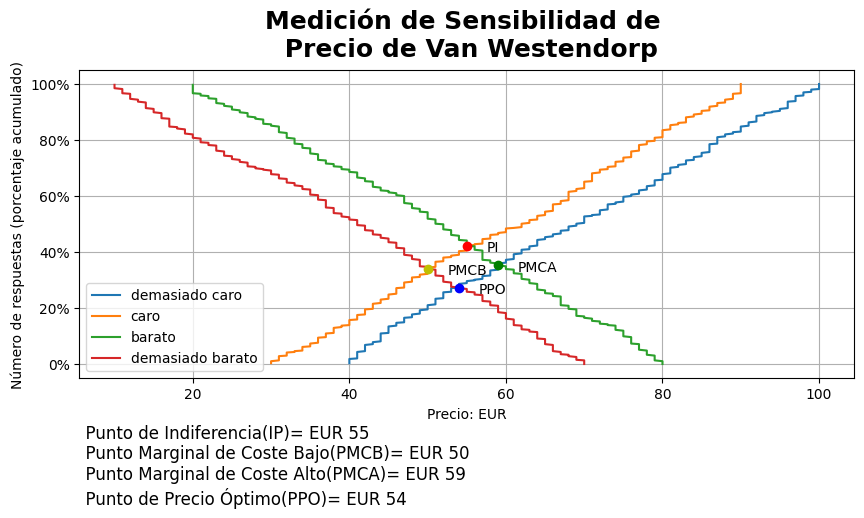

In [1]:
%run van_westendorp_es.py 

archivo = 'vwsurvey_es.csv' # ingrese aquí el nombre de su archivo
# La moneda por defecto es EUR, puedes cambiarla pasándola como segundo argumento de tipo string
# van_westendorp(archivo, "USD")
van_westendorp(archivo)
# Un PNG del gráfico se guarda en el directorio actual, para que pueda descargarlo. También puedes copiarlo
# al portapapeles haciendo clic en el icono "copiar" a continuación

# Este primer bloque es opcional.
Úsalo si aún no tienes los datos de tu encuesta para simularlos y almacenarlos en un archivo. `generar_archivo_aleatorio(n)` es una función, donde n es de tipo int y es el número de filas deseadas. La función generará un csv, un json y un xlsx, todos con la misma información.

In [2]:
from random import randint
import json
import csv
import pandas as pd


def generar_archivo_aleatorio(n):
  data = []
  for i in range(n):
    data.append({
        "Demasiado Barato": randint(10, 70),
        "Barato": randint(20, 80),
        "Caro": randint(30, 90),
        "Demasiado Caro": randint(40, 100)
    })

  with open('vwsurvey_es.json', 'w') as output_file_json:
    output_file_json.write(json.dumps(data))
  
  with open('vwsurvey_es.csv', 'w', newline='') as output_file:
    writer = csv.DictWriter(output_file, fieldnames=data[0].keys())
    writer.writeheader()

    for row in data:
      writer.writerow(row)

  with open('vwsurvey_es.xlsx', 'w') as output_file_excel:
    df = pd.DataFrame(data)
    df.to_excel("vwsurvey_es.xlsx", index=False)


In [3]:
data = generar_archivo_aleatorio(50)

In [4]:
# Configuración de los tests
!pip install ipytest
import pytest
import ipytest
ipytest.autoconfig()


Las celdas que están colapsadas y comienzan con `%%ipytest -qq` son pruebas. Puedes abrirlas y comprobar.

In [5]:
%%ipytest -qq
# Testea generar_archivo_aleatorio(n)
def test_output():
    columnas = [ "Demasiado Barato", "Barato", "Caro","Demasiado Caro" ]
    n = randint(1, 500)
    generar_archivo_aleatorio(n)
    df_csv = pd.read_csv('vwsurvey_es.csv')
    assert df_csv.shape == (n, 4)
    assert set(df_csv.columns) == set(columnas)
    df_json = pd.read_json('vwsurvey_es.json')
    assert df_json.shape == (n, 4)
    assert set(df_json.columns) == set(columnas)
    df_excel = pd.read_excel('vwsurvey_es.xlsx') 
    assert df_excel.shape == (n, 4)
    assert set(df_excel.columns) == set(columnas) 

.                                                                                            [100%]


## Primer paso: preparar los datos para graficar

In [6]:
import pandas as pd
import numpy as np


precios = {'Demasiado Barato': [100,120,200,200,300,100,100,300,100,350,340,450,100,257,109,109,280,400,250,200],
          'Barato': [150,200,250,300,340,190,200,350,120,360,360,460,110,388,299,129,350,410,260,240],
          'Caro': [400,400,450,350,400,200,300,370,180,370,490,490,130,433,399,149,400,420,270,280],
          'Demasiado Caro': [500,480,500,400,490,300,500,380,200,380,500,500,140,499,422,199,410,430,280,300],
        }
# Usamos el diccionario para crear un marco de datos de longitud 20
df = pd.DataFrame(precios)
# Elimina espacios y pone en minúsculas las etiquetas de las columnas
df.columns = df.columns.str.strip().str.lower()
print(f'Longitud del data frame es {df.index.stop}')

# Crea dos nuevas columnas llamadas "FRA" y "1 - FRA" que significa Frecuencia Relativa Acumulada
df['FRA'] = (np.arange(1, df.index.stop + 1, 1)/df.index.stop).round(3)
# Usando numpy np.arange(start, stop, step) creamos una nueva matriz que comienza en 1, se detiene en la longitud del data frame,
# aumenta en una unidad cada iteración, divide dicho valor por la longitud del dataframe y lo redondea a tres decimales
# Entonces el primer valor será: (1/20)*round(3) = 0.05
# El segundo valor será: (2/20)*round(3) = 0.10
# Y así sucesivamente hasta que el último sea: (20/20)*round(3) = 1.00
df['1 - FRA'] = 1 - df['FRA']
# Para obtener el valor inverso, restamos 1 menos el valor obtenido antes
df

Longitud del data frame es 20


,demasiado barato,barato,caro,demasiado caro,FRA,1 - FRA
0,100,150,400,500,0.05,0.95
1,120,200,400,480,0.10,0.90
2,200,250,450,500,0.15,0.85
3,200,300,350,400,0.20,0.80
4,300,340,400,490,0.25,0.75
5,100,190,200,300,0.30,0.70
6,100,200,300,500,0.35,0.65
7,300,350,370,380,0.40,0.60
8,100,120,180,200,0.45,0.55
9,350,360,370,380,0.50,0.50


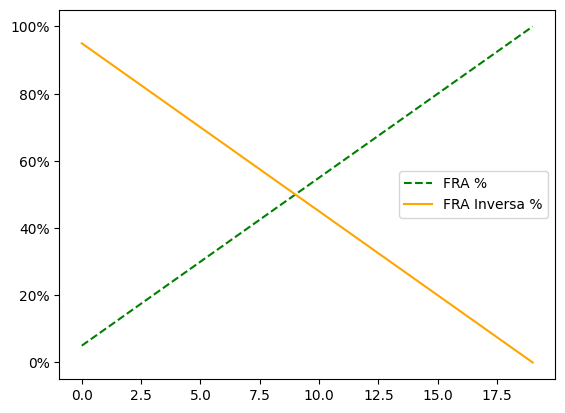

In [7]:
# Si trazamos estas dos columnas como líneas separadas con coordenadas x correspondientes a sus
# índices y las coordenadas "y" correspondientes a sus valores, evidenciamos que FRA es una línea con 
# pendiente positiva mientras que "1- FRA" tiene una pendiente negativa
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter # to format the y axis as percentage
fig, ax = plt.subplots()

ax.plot(df["FRA"].index, df['FRA'], color="green", linestyle="dashed", label="FRA %")
ax.plot(df['1 - FRA'].index, df['1 - FRA'], color="orange", label="FRA Inversa %")
ax.yaxis.set_major_formatter(FuncFormatter(lambda y, _: '{:.0%}'.format(y))) # to format the y axis as percentage
ax.legend()
plt.show()


In [8]:
# Existe la posibilidad de que los valores se repitan. En este caso 500 es el valor "demasiado caro" más frecuente
ordenado_demasiado_caro = sorted(df["demasiado caro"]) #ordena esta columna y la almacena en una nueva variable
nuevo_df = pd.DataFrame( ) #crea un nuevo dataframe
nuevo_df["ordenado_demasiado_caro"] = ordenado_demasiado_caro # nueva columna con artículos ordenados
nuevo_df["FRA"] = df["FRA"] # nueva columna con valores de CPer
nuevo_df # nuevo marco de datos con valores "demasiado caros" y CPer


,ordenado_demasiado_caro,FRA
0,140,0.05
1,199,0.10
2,200,0.15
3,280,0.20
4,300,0.25
5,300,0.30
6,380,0.35
7,380,0.40
8,400,0.45
9,410,0.50


Esta es la información que graficaremos más tarde, pero primero, sólo para practicar un poco más la manipulación de datos, calculemos la frecuencia de cada valor.


In [9]:
cuenta = nuevo_df['ordenado_demasiado_caro'].value_counts().sort_index()
print(cuenta)

# Esto mostrará  el precio "demasiado caro" de cada encuestado y su frecuencia.
# En este caso, 500 es la respuesta más frecuente con 5

140    1
199    1
200    1
280    1
300    2
380    2
400    1
410    1
422    1
430    1
480    1
490    1
499    1
500    5
Name: ordenado_demasiado_caro, dtype: int64


Creamos otro data frame para evaluar la frecuencia.


In [10]:
frecuencia_df = pd.DataFrame() # nuevo data frame
suma_acumulada = cuenta.cumsum() # Provee precio "demasiado_caro" como clave y frecuencia
# acumulada como valor
print(suma_acumulada)


140     1
199     2
200     3
280     4
300     6
380     8
400     9
410    10
422    11
430    12
480    13
490    14
499    15
500    20
Name: ordenado_demasiado_caro, dtype: int64


In [11]:
frecuencia_df["precio"] = suma_acumulada.index # new column with prices
frecuencia_df["frecuencia"] = cuenta.values # new column with frequency values
frecuencia_df["frecuencia relativa"] = (cuenta.values/len(frecuencia_df)).round(3)*100 # Ya que la longitud de este data frame es
# más corta, todos los valores relativos también han cambiado, lo que requiere que se vuelvan a calcular
frecuencia_df["frecuencia acumulada absoluta (%)"] = suma_acumulada.values 
frecuencia_df["frecuencia acumulada relativa (%)"] =  (np.arange(1, frecuencia_df.index.stop + 1, 1)/frecuencia_df.index.stop).round(3) 
frecuencia_df["frecuencia acumulada relativa inversa (%)"] = 1 - frecuencia_df["frecuencia acumulada relativa (%)"]
frecuencia_df.info()
# El nuevo dataframe tiene ahora 14 filas porque ahora está agrupado por frecuencia

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14 entries, 0 to 13
Data columns (total 6 columns):
 #   Column                                     Non-Null Count  Dtype  
---  ------                                     --------------  -----  
 0   precio                                     14 non-null     int64  
 1   frecuencia                                 14 non-null     int64  
 2   frecuencia relativa                        14 non-null     float64
 3   frecuencia acumulada absoluta (%)          14 non-null     int64  
 4   frecuencia acumulada relativa (%)          14 non-null     float64
 5   frecuencia acumulada relativa inversa (%)  14 non-null     float64
dtypes: float64(3), int64(3)
memory usage: 800.0 bytes


En la siguiente celda veremos el dataframe `frecuencia_df` que construimos para la respuesta "demasiado caro", ordenado de forma ascendente por valor. Más tarde, cuando creemos el gráfico, dibujaremos una línea por cada columna ("demasiado barato", "barato", "caro", "demasiado caro") usando sus valores ordenados en ascenso para las coordenadas x. Y como queremos que las líneas "demasiado baratas" y "baratas" se crucen con "caras" y "demasiado caras", usamos el porcentaje acumulativo inverso para generar líneas de pendiente negativa para "demasiado barato" y "barato" ("y" será más pequeña para cada valor x) y el porcentaje acumulativo para los otros dos.

In [12]:
frecuencia_df

,precio,frecuencia,frecuencia relativa,frecuencia acumulada absoluta (%),frecuencia acumulada relativa (%),frecuencia acumulada relativa inversa (%)
0,140,1,7.1,1,0.071,0.929
1,199,1,7.1,2,0.143,0.857
2,200,1,7.1,3,0.214,0.786
3,280,1,7.1,4,0.286,0.714
4,300,2,14.3,6,0.357,0.643
5,380,2,14.3,8,0.429,0.571
6,400,1,7.1,9,0.500,0.500
7,410,1,7.1,10,0.571,0.429
8,422,1,7.1,11,0.643,0.357
9,430,1,7.1,12,0.714,0.286


Ahora graficamos las líneas

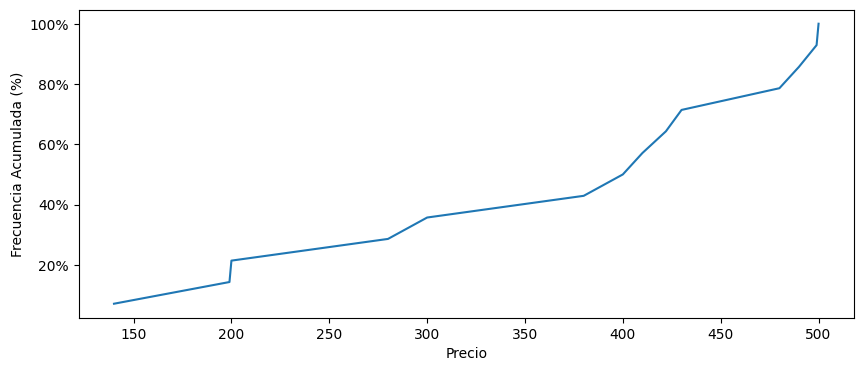

In [13]:
fig, ax = plt.subplots(figsize=(10, 4))
ax.plot(frecuencia_df["precio"], frecuencia_df["frecuencia acumulada relativa (%)"])
ax.set_xlabel('Precio')
ax.set_ylabel('Frecuencia Acumulada (%)')
ax.yaxis.set_major_formatter(FuncFormatter(lambda y, _: '{:.0%}'.format(y))) 
plt.show()


Evidenciamos que (con el precio como coordenada x y la frecuencia acumulada como coordenada y):
primer punto = 140, 7,1%
segundo punto = 199, 14,3%
tercer punto = 200, 21,4%
Entre el primer y el segundo punto, observamos un cambio de 59 puntos en la coordenada x y el doble de puntos en la coordenada y,
mientras que el cambio en x es solo de un punto y el cambio en "y" es la mitad de los puntos. Por eso, la pendiente es muy pronunciada.

## Segundo paso: graficar las líneas

Ahora volvemos al data frame original y trazamos todas las líneas.

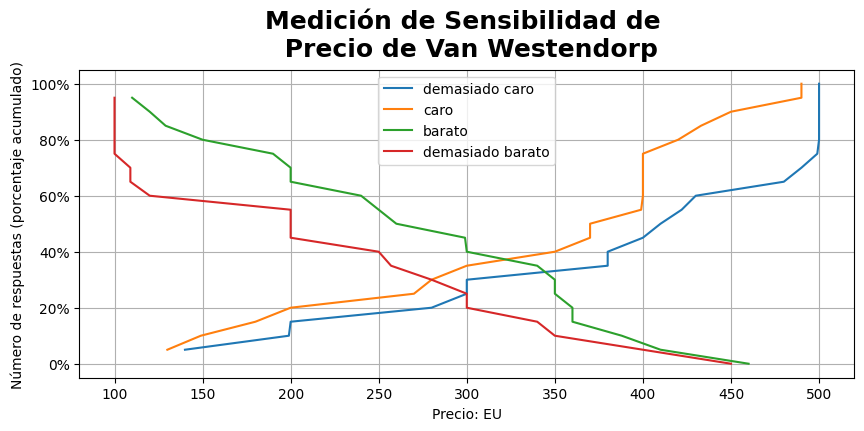

In [14]:
fig, ax = plt.subplots(figsize=(10, 4))
ax.plot(df["demasiado caro"].sort_values(), df["FRA"])
ax.plot(df["caro"].sort_values(), df["FRA"])
ax.plot(df["barato"].sort_values(), df["1 - FRA"])
ax.plot(df["demasiado barato"].sort_values(), df["1 - FRA"])
ax.legend(["demasiado caro", "caro", "barato", "demasiado barato"], loc="best")
ax.set_title(
    """Medición de Sensibilidad de \n Precio de Van Westendorp""",
    pad=10,
    size=18,
    fontweight="bold",
    loc="center",
)
ax.set_xlabel(f"Precio: EU") # configura la etiqueta del eje de las abcisas, luego este 
# valor será dinámico en función del input del usuario
ax.set_ylabel("Número de respuestas (porcentaje acumulado)") # configura la etiqueta del eje de las ordenadas
ax.yaxis.set_major_formatter(FuncFormatter(lambda y, _: "{:.0%}".format(y)))
ax.grid(True) # añade la cuadrícula
plt.show()

## Tercer Paso: encontrar y etiquetar intercepciones

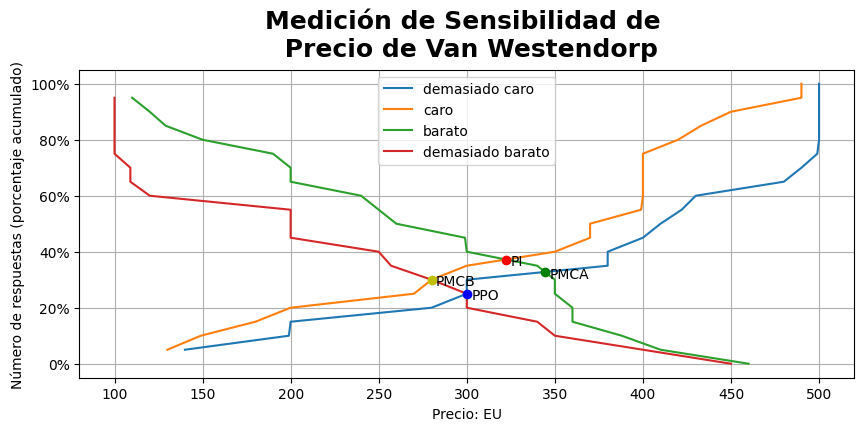

In [15]:
import shapely
from shapely.geometry import LineString

##### INICIA CÓDIGO PREVIO #######
fig, ax = plt.subplots(figsize=(10, 4))
ax.plot(df["demasiado caro"].sort_values(), df["FRA"])
ax.plot(df["caro"].sort_values(), df["FRA"])
ax.plot(df["barato"].sort_values(), df["1 - FRA"])
ax.plot(df["demasiado barato"].sort_values(), df["1 - FRA"])
ax.legend(["demasiado caro", "caro", "barato", "demasiado barato"], loc="best")
ax.set_title(
    """Medición de Sensibilidad de \n Precio de Van Westendorp""",
    pad=10,
    size=18,
    fontweight="bold",
    loc="center",
)
ax.set_xlabel(f"Precio: EU") # configura la etiqueta del eje de las abcisas, luego este 
# valor será dinámico en función del input del usuario
ax.set_ylabel("Número de respuestas (porcentaje acumulado)") # configura la etiqueta del eje de las ordenadas
ax.yaxis.set_major_formatter(FuncFormatter(lambda y, _: "{:.0%}".format(y)))
ax.grid(True) # añade la cuadrícula

##### FINALIZA CÓDIGO PREVIO #######


# Usamos el método interception del objeto LineString de la librería shapely 

demasiado_caro = LineString(
        list(zip(df["demasiado caro"].sort_values(), df["FRA"]))
    )
caro = LineString(list(zip(df["caro"].sort_values(), df["FRA"])))
barato = LineString(list(zip(df["barato"].sort_values(), df["1 - FRA"])))
demasiado_barato = LineString(
    list(zip(df["demasiado barato"].sort_values(), df["1 - FRA"]))
)

"""
- Intersección de "barato" y "caro" es el Punto de Indiferencia (PI)
- Intersección de "barato" y "demasiado caro" es el Punto Marginal de Coste Alto (PMCA)
- Intersección de "demasiado barato" y "caro" es el Punto Marginal de Coste Bajo (PMCB)
- Intersección de "demasiado barato" y "demasiado caro" es el Punto de Precio Óptimo
"""

interseccion_1 = caro.intersection(barato)
interseccion_2 = demasiado_caro.intersection(barato)
interseccion_3 = caro.intersection(demasiado_barato)
interseccion_4 = demasiado_caro.intersection(demasiado_barato)
puntos_interseccion = [
    interseccion_1,
    interseccion_2,
    interseccion_3,
    interseccion_4,
] # guardamos todas las intercepciones en un array

for i, interseccion in enumerate(puntos_interseccion):
    if type(interseccion) != shapely.geometry.point.Point:
        puntos_interseccion[i] = interseccion.interpolate(0)
# algunas veces las líneas pueden solaparse en un sector. En ese caso tomaremos 
# como intercepción el primer punto
indicadores = ["ro", "go", "yo", "bo"] # esto significa red (rojo), green(verde), yellow(amarillo) y blue (azul), 
# la o es de oval(óvalo) para que cada etiqueta sea circular con esos colores
for punto, indicador in zip(puntos_interseccion, indicadores):
    ax.plot(*punto.xy, indicador)
# Redondeamos la coordenada x de cada punto en cada etiqueta de texto
PI = round(puntos_interseccion[0].x)
PMCA = round(puntos_interseccion[1].x)
PMCB = round(puntos_interseccion[2].x)
PPO = round(puntos_interseccion[3].x)

# Aquí afinamos la posición de las etiquetas
ax.annotate(
    "PI", xy=(puntos_interseccion[0].x + 2.5, puntos_interseccion[0].y - 0.02)
)
ax.annotate(
    "PMCA", xy=(puntos_interseccion[1].x + 2.5, puntos_interseccion[1].y - 0.02)
)
ax.annotate(
    "PMCB", xy=(puntos_interseccion[2].x + 2.5, puntos_interseccion[2].y - 0.02)
)
ax.annotate(
    "PPO", xy=(puntos_interseccion[3].x + 2.5, puntos_interseccion[3].y - 0.02)
)
plt.show()

## Cuarto Paso: Agregar el bloque de texto informativo

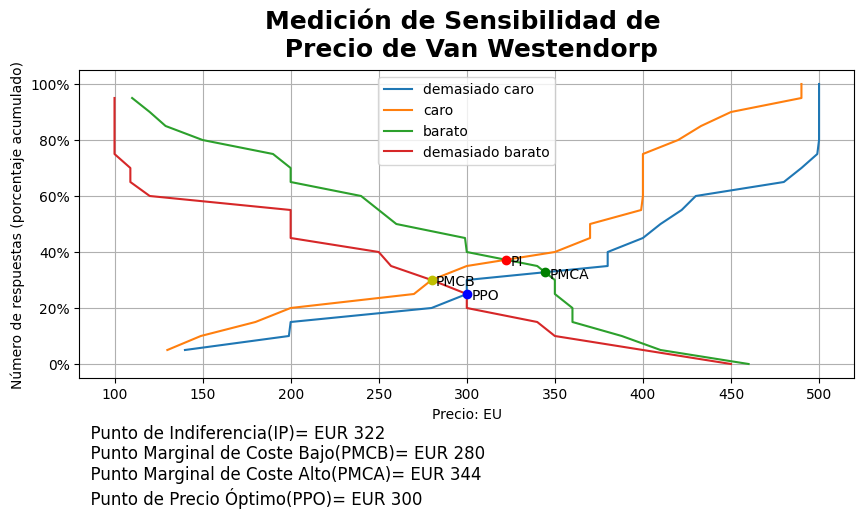

In [16]:
##### INICIA CÓDIGO PREVIO #######
fig, ax = plt.subplots(figsize=(10, 4))
ax.plot(df["demasiado caro"].sort_values(), df["FRA"])
ax.plot(df["caro"].sort_values(), df["FRA"])
ax.plot(df["barato"].sort_values(), df["1 - FRA"])
ax.plot(df["demasiado barato"].sort_values(), df["1 - FRA"])
ax.legend(["demasiado caro", "caro", "barato", "demasiado barato"], loc="best")
ax.set_title(
    """Medición de Sensibilidad de \n Precio de Van Westendorp""",
    pad=10,
    size=18,
    fontweight="bold",
    loc="center",
)
ax.set_xlabel(f"Precio: EU") # configura la etiqueta del eje de las abcisas, luego este 
# valor será dinámico en función del input del usuario
ax.set_ylabel("Número de respuestas (porcentaje acumulado)") # configura la etiqueta del eje de las ordenadas
ax.yaxis.set_major_formatter(FuncFormatter(lambda y, _: "{:.0%}".format(y)))
ax.grid(True) # añade la cuadrícula

# Usamos el método interception del objeto LineString de la librería shapely 

demasiado_caro = LineString(
        list(zip(df["demasiado caro"].sort_values(), df["FRA"]))
    )
caro = LineString(list(zip(df["caro"].sort_values(), df["FRA"])))
barato = LineString(list(zip(df["barato"].sort_values(), df["1 - FRA"])))
demasiado_barato = LineString(
    list(zip(df["demasiado barato"].sort_values(), df["1 - FRA"]))
)

"""
- Intersección de "barato" y "caro" es el Punto de Indiferencia (PI)
- Intersección de "barato" y "demasiado caro" es el Punto Marginal de Coste Alto (PMCA)
- Intersección de "demasiado barato" y "caro" es el Punto Marginal de Coste Bajo (PMCB)
- Intersección de "demasiado barato" y "demasiado caro" es el Punto de Precio Óptimo
"""

interseccion_1 = caro.intersection(barato)
interseccion_2 = demasiado_caro.intersection(barato)
interseccion_3 = caro.intersection(demasiado_barato)
interseccion_4 = demasiado_caro.intersection(demasiado_barato)
puntos_interseccion = [
    interseccion_1,
    interseccion_2,
    interseccion_3,
    interseccion_4,
] # guardamos todas las intercepciones en un array

for i, interseccion in enumerate(puntos_interseccion):
    if type(interseccion) != shapely.geometry.point.Point:
        puntos_interseccion[i] = interseccion.interpolate(0)
# algunas veces las líneas pueden solaparse en un sector. En ese caso tomaremos 
# como intercepción el primer punto
indicadores = ["ro", "go", "yo", "bo"] # esto significa red (rojo), green(verde), yellow(amarillo) y blue (azul), 
# la o es de oval(óvalo) para que cada etiqueta sea circular con esos colores
for punto, indicador in zip(puntos_interseccion, indicadores):
    ax.plot(*punto.xy, indicador)
# Redondeamos la coordenada x de cada punto en cada etiqueta de texto
PI = round(puntos_interseccion[0].x)
PMCA = round(puntos_interseccion[1].x)
PMCB = round(puntos_interseccion[2].x)
PPO = round(puntos_interseccion[3].x)

# Aquí afinamos la posición de las etiquetas
ax.annotate(
    "PI", xy=(puntos_interseccion[0].x + 2.5, puntos_interseccion[0].y - 0.02)
)
ax.annotate(
    "PMCA", xy=(puntos_interseccion[1].x + 2.5, puntos_interseccion[1].y - 0.02)
)
ax.annotate(
    "PMCB", xy=(puntos_interseccion[2].x + 2.5, puntos_interseccion[2].y - 0.02)
)
ax.annotate(
    "PPO", xy=(puntos_interseccion[3].x + 2.5, puntos_interseccion[3].y - 0.02)
)
ax.text(
        80.5,
        -0.5,
        f"""  Punto de Indiferencia(IP)= EUR {str(f'{PI:,}')}
  Punto Marginal de Coste Bajo(PMCB)= EUR {str(f'{PMCB:,}')}
  Punto Marginal de Coste Alto(PMCA)= EUR {str(f'{PMCA:,}')}
  Punto de Precio Óptimo(PPO)= EUR {str(f'{PPO:,}')}""",
        fontsize=12,
    )
plt.show()

¡Lo tenemos! Ahora creamos una función para agrupar todo lo que hemos hecho hasta ahora

In [17]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter
import shapely
from shapely.geometry import LineString
# Moneda es un parámetro opcional, que tiene "EUR" como valor por defecto

def van_westendorp(data, moneda="EUR"):
    # Verifica que el archivo utilizado esté admitido y lanza un error cuando no
    
    if os.path.exists(data):
        if data.endswith("json"):
            df = pd.read_json(data)
        elif data.endswith("csv"):
            df = pd.read_csv(data)
        elif data.endswith("xlsx") or data.endswith("xls"):
            df = pd.read_excel(data)
        else:
            raise Exception("Tipo de archivo no admitido")
    else:
        raise Exception("Archivo no encontrado, revisa errores en el nombre")

    # Elimina filas con celdas vacías
    # Verificación rápida de integridad y formato
    # Elimina espacios en blanco y pone en minúsculas las etiquetas de las columnas
    df.dropna()
    df.columns = df.columns.str.strip().str.lower()
    columnas = ["demasiado barato", "barato", "caro", "demasiado caro"]

    if set(df.columns) != set(columnas):
        raise Exception(
            "Las columnas no cumplen con los requerimientos. Verifica los nombres"
        )

    df.columns = df.columns.str.strip().str.lower()
    df["FRA"] = (np.arange(1, df.index.stop + 1, 1) / df.index.stop).round(3)
    df["1 - FRA"] = 1 - df["FRA"]

    """
    PI= Punto de Indiferencia
    PMCB = Punto Marginal de Costo Bajo
    PMCA = Punto Marginal de Costo Alto
    PPO = Punto de Precio Óptimo
    """
    fig, ax = plt.subplots(figsize=(10, 4))
    ax.plot(df["demasiado caro"].sort_values(), df["FRA"])
    ax.plot(df["caro"].sort_values(), df["FRA"])
    ax.plot(df["barato"].sort_values(), df["1 - FRA"])
    ax.plot(df["demasiado barato"].sort_values(), df["1 - FRA"])
    ax.legend(["demasiado caro", "caro", "barato", "demasiado barato"], loc="best")
    ax.set_title(
        """Medición de Sensibilidad de \n Precio de Van Westendorp""",
        pad=10,
        size=18,
        fontweight="bold",
        loc="center",
    )
    ax.set_xlabel(f"Precio: {moneda}")
    ax.set_ylabel("Número de respuestas (porcentaje acumulado)")
    ax.yaxis.set_major_formatter(FuncFormatter(lambda y, _: "{:.0%}".format(y)))
    ax.grid(True) # añade la cuadrícula
    # Usamos el método interception del objeto LineString de la librería shapely 
    demasiado_caro = LineString(
        list(zip(df["demasiado caro"].sort_values(), df["FRA"]))
    )
    caro = LineString(list(zip(df["caro"].sort_values(), df["FRA"])))
    barato = LineString(list(zip(df["barato"].sort_values(), df["1 - FRA"])))
    demasiado_barato = LineString(
        list(zip(df["demasiado barato"].sort_values(), df["1 - FRA"]))
    )

    """
    - Intersección de "barato" y "caro" es el Punto de Indiferencia (PI)
    - Intersección de "barato" y "demasiado caro" es el Punto Marginal de Coste Alto (PMCA)
    - Intersección de "demasiado barato" y "caro" es el Punto Marginal de Coste Bajo (PMCB)
    - Intersección de "demasiado barato" y "demasiado caro" es el Punto de Precio Óptimo
    """

    interseccion_1 = caro.intersection(barato)
    interseccion_2 = demasiado_caro.intersection(barato)
    interseccion_3 = caro.intersection(demasiado_barato)
    interseccion_4 = demasiado_caro.intersection(demasiado_barato)
    puntos_interseccion = [
        interseccion_1,
        interseccion_2,
        interseccion_3,
        interseccion_4,
    ]# guardamos todas las intercepciones en un array

    for i, interseccion in enumerate(puntos_interseccion):
        if type(interseccion) != shapely.geometry.point.Point:
            puntos_interseccion[i] = interseccion.interpolate(0)

    # algunas veces las líneas pueden solaparse en un sector. En ese caso tomaremos 
    # como intercepción el primer punto
    indicadores = ["ro", "go", "yo", "bo"] # esto significa red (rojo), green(verde), yellow(amarillo) y blue (azul), 

    # la o es de oval(óvalo) para que cada etiqueta sea circular con esos colores
    for punto, indicador in zip(puntos_interseccion, indicadores):
        ax.plot(*punto.xy, indicador)
    # Redondeamos la coordenada x de cada punto en cada etiqueta de texto
    PI = round(puntos_interseccion[0].x)
    PMCA = round(puntos_interseccion[1].x)
    PMCB = round(puntos_interseccion[2].x)
    PPO = round(puntos_interseccion[3].x)
    # Aquí afinamos la posición de las etiquetas
    ax.annotate(
        "PI", xy=(puntos_interseccion[0].x + 2.5, puntos_interseccion[0].y - 0.02)
    )
    ax.annotate(
        "PMCA", xy=(puntos_interseccion[1].x + 2.5, puntos_interseccion[1].y - 0.02)
    )
    ax.annotate(
        "PMCB", xy=(puntos_interseccion[2].x + 2.5, puntos_interseccion[2].y - 0.02)
    )
    ax.annotate(
        "PPO", xy=(puntos_interseccion[3].x + 2.5, puntos_interseccion[3].y - 0.02)
    )
    ax.text(
        5,
        -0.5,
        f"""  Punto de Indiferencia(IP)= {moneda} {str(f'{PI:,}')}
  Punto Marginal de Coste Bajo(PMCB)= {moneda} {str(f'{PMCB:,}')}
  Punto Marginal de Coste Alto(PMCA)= {moneda} {str(f'{PMCA:,}')}
  Punto de Precio Óptimo(PPO)= {moneda} {str(f'{PPO:,}')}""",
        fontsize=12,
    )

    plt.show()
    
  


Tests de las verificaciones de integridad

In [20]:
%%ipytest -qq
# Testea van_westendorp_es(archivo)

def test_van_westendorp_raises_exception_on_unexistent_file():
    with pytest.raises(Exception) as excinfo:
        van_westendorp("vwsurvey.png")
    assert excinfo.match(
        "Archivo no encontrado, revisa errores en el nombre"
    ), f"Unexpected exception message: {excinfo.value}"


def test_van_westendorp_raises_exception_on_invalid_file_type():
    with pytest.raises(Exception) as excinfo:
        van_westendorp("output.png")

    assert excinfo.match(
        "Tipo de archivo no admitido"
    ), f"Unexpected exception message: {excinfo.value}"


def test_van_westendorp_raises_exception_on_features_names():
    with pytest.raises(Exception) as excinfo:
        van_westendorp("vwsurveybad.csv")

    assert excinfo.match(
        "Las columnas no cumplen con los requerimientos. Verifica los nombres"
    ), f"Unexpected exception message: {excinfo.value}"


F...                                                                                         [100%]
============================================= FAILURES =============================================
___________________________________________ test_output ____________________________________________

    def test_output():
>     van_westendorp("vwsurvey.png")

/var/folders/f5/3c4zlsdd0t1gvnqhpjc0njm00000gn/T/ipykernel_50746/3071708245.py:5: 
_ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ 

data = 'vwsurvey.png', moneda = 'EUR'

    def van_westendorp(data, moneda="EUR"):
        # Verifica que el archivo utilizado esté admitido y lanza un error cuando no
    
        if os.path.exists(data):
            if data.endswith("json"):
                df = pd.read_json(data)
            elif data.endswith("csv"):
                df = pd.read_csv(data)
            elif data.endswith("xlsx") or data.endswith("xls"):
                df = pd.r

Para generar el gráfico de Van Westendorp, debes agregar tu archivo a este directorio. Admite archivos csv, json y excel. Si no tienes un archivo, puede simular uno, como se explicó anteriormente

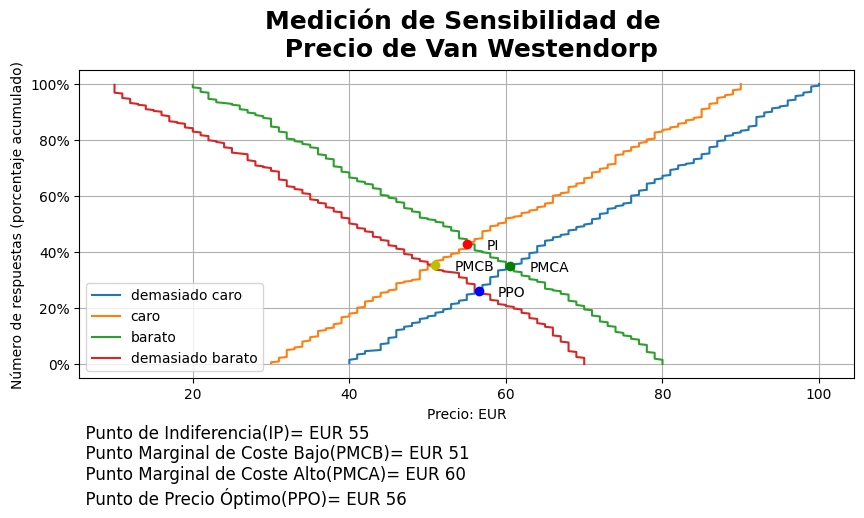

In [19]:
archivo = 'vwsurvey_es.csv' # ingrese aquí el nombre de su archivo
# La moneda por defecto es EUR, puedes cambiarla pasándola como segundo argumento de tipo string
# van_westendorp(archivo, "USD")
van_westendorp(archivo)
# Un PNG del gráfico se guarda en el directorio actual, para que pueda descargarlo. También puedes copiarlo
# al portapapeles haciendo clic en el icono "copiar" a continuación